In [1]:
import numpy as np

import tensorflow as tf

from PIL import Image as Img
import os

import mtcnn

from os import listdir, environ
from os.path import isfile, join
import time

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

my_image_path = "../../faces/"
dataset_image_path = "../../../Dataset/data/lfw/"
database = r"../../../Dataset/database/SmartFinder.db"

## Load Model

In [2]:
tf_lite_model = tf.lite.Interpreter(model_path='../../tflite/facenet.tflite')
tf_lite_model.allocate_tensors()

input_details = tf_lite_model.get_input_details()
output_details = tf_lite_model.get_output_details()

print("== Input details ==")
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])
print("\n== Output details ==")
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
shape: [  1 160 160   3]
type: <class 'numpy.float32'>

== Output details ==
shape: [  1 512]
type: <class 'numpy.float32'>


In [3]:
def get_image_embedding(image_path, tf_lite_model):
    # Open image
    image = Img.open(image_path).convert('RGB')
    pixels = np.asarray(image)
    # detect faces in the image
    detector = mtcnn.MTCNN()
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    if len(results) != 1:
        return np.array([])
    x1, y1, width, height = results[0]['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Img.fromarray(face)
    image = image.resize((160, 160))
    face_array = np.asarray(image)
    face_array_norm = face_array /255
    
    input_details = tf_lite_model.get_input_details()
    output_details = tf_lite_model.get_output_details()

    tf_lite_model.set_tensor(input_details[0]['index'], face_array_norm.reshape(1,160,160,3).astype(np.float32))
    tf_lite_model.invoke()

    return tf_lite_model.get_tensor(output_details[0]['index'])

## Load new embeddings

In [4]:
class NewPerson():
    def __init__(self, name, embedding):
        self.name = name
        self.embedding = embedding
        
    def set_id(self, _id):
        self.id = _id

In [5]:
start_time = time.time()

new_person_list = []

count = 0
for person_name in sorted(listdir(dataset_image_path))[:1300] + sorted(listdir(dataset_image_path))[4300:]:

    for image_path in sorted(listdir(dataset_image_path+person_name))[3:6]:
        embedding = get_image_embedding(dataset_image_path+person_name+'/'+image_path, tf_lite_model)
        if embedding.shape == (1, 512):
            person = NewPerson(person_name, embedding)
            new_person_list.append(person)

            #print("{} --- {:0.2f} minutes ---".format(person_name, (time.time() - start_time)/60))
            
    count += 1
    if count % 100 == 0:
        print("{}: {} fotos --- {:0.2f} minutes ---".format(count, len(new_person_list), (time.time() - start_time)/60))
    
print("\nTotal time: {:0.2f} minutes".format((time.time() - start_time)/60))

new_embeddings = np.array([person.embedding for person in new_person_list])

print("{} fotos novas".format(new_embeddings.shape[0]))

100: 20 fotos --- 0.59 minutes ---
200: 33 fotos --- 0.97 minutes ---
300: 58 fotos --- 1.61 minutes ---
400: 89 fotos --- 2.55 minutes ---
500: 104 fotos --- 2.95 minutes ---
600: 130 fotos --- 3.70 minutes ---
700: 143 fotos --- 4.08 minutes ---
800: 164 fotos --- 4.66 minutes ---
900: 187 fotos --- 5.38 minutes ---
1000: 199 fotos --- 5.71 minutes ---
1100: 224 fotos --- 6.41 minutes ---
1200: 227 fotos --- 6.49 minutes ---
1300: 246 fotos --- 6.98 minutes ---
1400: 257 fotos --- 7.32 minutes ---
1500: 274 fotos --- 7.86 minutes ---
1600: 300 fotos --- 8.46 minutes ---
1700: 320 fotos --- 9.11 minutes ---
1800: 341 fotos --- 9.68 minutes ---
1900: 361 fotos --- 10.27 minutes ---
2000: 386 fotos --- 10.89 minutes ---
2100: 407 fotos --- 11.54 minutes ---
2200: 416 fotos --- 11.81 minutes ---
2300: 423 fotos --- 12.11 minutes ---
2400: 441 fotos --- 12.63 minutes ---
2500: 475 fotos --- 13.53 minutes ---
2600: 507 fotos --- 14.38 minutes ---
2700: 541 fotos --- 15.25 minutes ---

Tota

## Free memory

In [6]:
del tf_lite_model
del input_details
del output_details
del start_time
del count

In [7]:
import gc
gc.collect()

24740

## Load Database

In [8]:
match_distance = 0.8
n_closer = 5
chunck_size=15

In [11]:
import time
from flask import Flask, request, jsonify
from flask_sqlalchemy import SQLAlchemy
from datetime import datetime, timedelta
#from flask_cors import CORS

print('verdadeiro_positivo | verdadeiro_negativo | falso_positivo |falso_negativo')

positivo = []
falso = []
num_pessoas = []
total = []

for db_size in range(100, 5200, 100):
    
    gc.collect()

    app = Flask(__name__)
    app.config['SQLALCHEMY_DATABASE_URI'] = 'sqlite:///../../../Dataset/database/SmartFinder_{}.db'.format(db_size) #'sqlite:///test.db'
    app.config['SQLALCHEMY_TRACK_MODIFICATIONS'] = False
    db = SQLAlchemy(app)

    #cors = CORS(app, resources={r"/*": {"origins": "*"}})

          #############
    ########  Utils  ########
          #############

    import numpy as np
    def get_distance(embedding_1, embedding_2):
        return np.linalg.norm(np.array(eval(embedding_1)) - np.array(eval(embedding_2)))

    def is_new_match(json_match, new_name):
        for match in json_match:
            if match['person_name'] == new_name:
                return False
        return True

          #############
    ########  Models ########
          #############

    class Person(db.Model):
        id = db.Column(db.Integer, primary_key=True, autoincrement=True)
        name = db.Column(db.String(200), nullable=False)
        birthday = db.Column(db.DateTime, nullable=False)
        status = db.Column(db.String(200), nullable=False)
        created_at = db.Column(db.DateTime, nullable=True)
        updated_at = db.Column(db.DateTime, nullable=True)
        images = db.relationship('Image', uselist=True, backref='person')
        matches = db.relationship('Match', uselist=True, backref='person')

    class Image(db.Model):
        id = db.Column(db.Integer, primary_key=True, autoincrement=True)
        person_id = db.Column(db.Integer, db.ForeignKey('person.id'), nullable=True)
        path = db.Column(db.String(200), nullable=False)
        embedding = db.Column(db.String(500), nullable=False)
        created_at = db.Column(db.DateTime, nullable=True)
        matches = db.relationship('Match', uselist=True, backref='image')

    class Request(db.Model):
        id = db.Column(db.Integer, primary_key=True, autoincrement=True)
        lat = db.Column(db.Integer, nullable=False)
        long = db.Column(db.Integer, nullable=False)
        embedding = db.Column(db.String(500), nullable=False)
        created_at = db.Column(db.DateTime, nullable=True)
        matches = db.relationship('Match', uselist=True, backref='request')

    class Match(db.Model):
        id = db.Column(db.Integer, primary_key=True, autoincrement=True)
        request_id = db.Column(db.Integer, db.ForeignKey('request.id'), nullable=True)
        image_id = db.Column(db.Integer, db.ForeignKey('image.id'), nullable=True)
        person_id = db.Column(db.Integer, db.ForeignKey('person.id'), nullable=True)
        distance = db.Column(db.Float, nullable=True)

    image_list = Image.query.all()
    db_embeddings = np.array([eval(image.embedding) for image in image_list])

    person_list = Person.query.all()
    person_ids = np.array([person.id for person in person_list])
    person_names = np.array([person.name for person in person_list])

    #print("Pessoas na base: ", len(person_ids))

    verdadeiro_positivo = 0
    verdadeiro_negativo = 0
    falso_positivo = 0
    falso_negativo = 0

    for chunck_low, chunck_high in zip(range(0, len(new_person_list), chunck_size), range(chunck_size, len(new_person_list)+chunck_size, chunck_size)):
        distances = np.linalg.norm(new_embeddings[chunck_low:chunck_high, None, :] - db_embeddings[None, :, :], axis=-1)

        for person, i in zip(new_person_list[chunck_low:chunck_high], range(0,len(distances))):
            if person.name in person_names:
                # Está no banco de dados e ...
                encontrou = False
                for person_id in [image_list[index].person_id for index in(np.where(distances[i]<match_distance)[0])]:
                #for person_id in [image_list[index].person_id for index in np.intersect1d(np.where(distances[i]<match_distance)[0], np.argpartition(distances[i].reshape(1, distances[i].shape[0])[0], n_closer)[:n_closer])]:
                    if person.name == Person.query.filter(Person.id == person_id).first().name:
                        # encontrou
                        encontrou = True
                        verdadeiro_positivo += 1
                        break;
                        #print("VP: ", person.name)
                if encontrou == False:
                    # não encontrou
                    verdadeiro_negativo += 1
                    #print("VN: ", person.name)

            else:
                # Não está no banco de dados e ...
                if len(np.where(distances[i]<match_distance)[0]) > 0:
                    # encontrou alguém
                    falso_positivo += 1
                    #print("FP: ", person.name)
                else:
                    # não encontrou
                    falso_negativo += 1
                    #print("FN: ", person.name)

    #print("verdadeiro_positivo: ", verdadeiro_positivo)
    #print("verdadeiro_negativo: ", verdadeiro_negativo)
    #print("falso_positivo: ", falso_positivo)
    #print("falso_negativo: ", falso_negativo)
    #print()
    
    print("{:04}: {:03} | {:03} | {:03} | {:03}".format(len(person_ids), 
                                                        verdadeiro_positivo, 
                                                        verdadeiro_negativo, 
                                                        falso_positivo, 
                                                        falso_negativo
                                                        ))
    
    positivo.append( verdadeiro_positivo/(verdadeiro_positivo+verdadeiro_negativo) )
    falso.append( falso_negativo/(falso_positivo+falso_negativo) )
    total.append( (verdadeiro_positivo+falso_negativo)/(verdadeiro_positivo+verdadeiro_negativo+falso_positivo+falso_negativo) )
    num_pessoas.append(len(person_ids))

verdadeiro_positivo | verdadeiro_negativo | falso_positivo |falso_negativo
0100: 024 | 001 | 007 | 519
0200: 035 | 004 | 012 | 500
0300: 058 | 013 | 015 | 465
0400: 077 | 018 | 019 | 437
0500: 097 | 026 | 019 | 409
0600: 110 | 029 | 022 | 390
0700: 122 | 033 | 021 | 375
0800: 144 | 036 | 022 | 349
0900: 157 | 038 | 022 | 334
1000: 180 | 041 | 021 | 309
1100: 184 | 044 | 021 | 302
1200: 195 | 047 | 022 | 287
1300: 195 | 047 | 023 | 286
1400: 195 | 047 | 024 | 285
1500: 195 | 047 | 024 | 285
1600: 195 | 047 | 024 | 285
1700: 195 | 047 | 025 | 284
1800: 195 | 047 | 025 | 284
1900: 195 | 047 | 027 | 282
2000: 195 | 047 | 029 | 280
2100: 195 | 047 | 029 | 280
2200: 195 | 047 | 029 | 280
2300: 195 | 047 | 029 | 280
2400: 195 | 047 | 032 | 277
2500: 195 | 047 | 032 | 277
2600: 195 | 047 | 035 | 274
2700: 195 | 047 | 035 | 274
2800: 195 | 047 | 037 | 272
2900: 195 | 047 | 037 | 272
3000: 195 | 047 | 040 | 269
3100: 195 | 047 | 041 | 268
3200: 195 | 047 | 041 | 268
3300: 195 | 047 | 042 | 267
3

In [12]:
import matplotlib.pyplot as plt

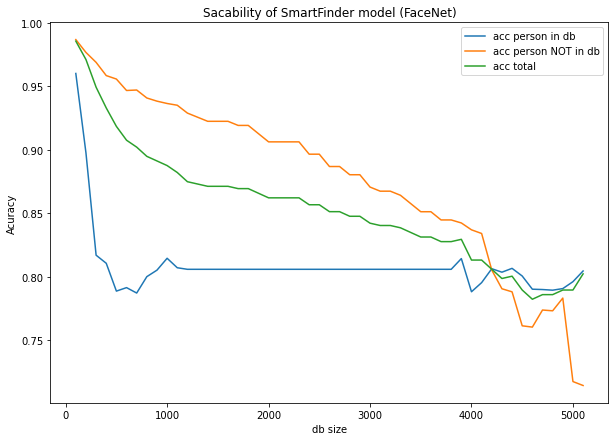

In [14]:
plt.figure(figsize=(10,7))

plt.plot(num_pessoas, positivo, label='acc person in db')
plt.plot(num_pessoas, falso, label='acc person NOT in db')
plt.plot(num_pessoas, total, label='acc total')

plt.title('Sacability of SmartFinder model (FaceNet)')
plt.ylabel('Acuracy')
plt.xlabel('db size')
plt.legend(loc="upper right")

plt.show()